In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from scipy.stats import ttest_ind, kstest

from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.calibration import calibration_curve

from imblearn.under_sampling import RandomUnderSampler

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import lightgbm as lgm
from xgboost import XGBClassifier

from tabpfn import TabPFNClassifier

from lofo import LOFOImportance, Dataset, plot_importance

import optuna

C:\Users\yaobv\anaconda3\envs\nick_wan_bb\lib\site-packages\lofo\lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def competition_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # Implements the Evaluation equation with w_0 = w_1 = 1.
    # Calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    # return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1)/2

In [3]:
def lgb_metric(y_true, y_pred):
    return 'competition_log_loss', competition_log_loss(y_true, y_pred), False

In [4]:
train_df = pd.read_csv('train.csv')
greek_df = pd.read_csv('greeks.csv')
test_df = pd.read_csv('test.csv')

train_df.columns = [col.strip() for col in train_df.columns]
train_df['EJ'] = train_df['EJ'].map({'B' : 0, 'A':1})

test_df.columns = [col.strip() for col in test_df.columns]
test_df['EJ'] = test_df['EJ'].map({'B': 0, 'A' : 1})

In [5]:
int_denominators = {
 'AB': 0.004273,
 'AF': 0.00242,
 'AH': 0.008709,
 'AM': 0.003097,
 'AR': 0.005244,
 'AX': 0.008859,
 'AY': 0.000609,
 'AZ': 0.006302,
 'BC': 0.007028,
 'BD': 0.00799,
 'BN': 0.3531,
 'BP': 0.004239,
 'BQ': 0.002605,
 'BR': 0.006049,
 'BZ': 0.004267,
 'CB': 0.009191,
 'CC': 6.12e-06,
 'CD': 0.007928,
 'CF': 0.003041,
 'CH': 0.000398,
 'CL': 0.006365,
 'CR': 7.5e-05,
 'CS': 0.003487,
 'CU': 0.005517,
 'CW': 9.2e-05,
 'DA': 0.00388,
 'DE': 0.004435,
 'DF': 0.000351,
 'DH': 0.002733,
 'DI': 0.003765,
 'DL': 0.00212,
 'DN': 0.003412,
 'DU': 0.0013794,
 'DV': 0.00259,
 'DY': 0.004492,
 'EB': 0.007068,
 'EE': 0.004031,
 'EG': 0.006025,
 'EH': 0.006084,
 'EL': 0.000429,
 'EP': 0.009269,
 'EU': 0.005064,
 'FC': 0.005712,
 'FD': 0.005937,
 'FE': 0.007486,
 'FI': 0.005513,
 'FR': 0.00058,
 'FS': 0.006773,
 'GB': 0.009302,
 'GE': 0.004417,
 'GF': 0.004374,
 'GH': 0.003721,
 'GI': 0.002572
}
for k, v in int_denominators.items():
    train_df[k] = np.round(train_df[k]/v,1)
    
for k, v in int_denominators.items():
    test_df[k] = np.round(test_df[k]/v,1)

In [6]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,49.0,1284724.5,9783.0,7231.0,1552.0,79.0,42.0,1557.0,790.5,...,7.298162,2997.5,14.0,1219.0,16439.0,458118.5,5949.0,27152.0,0.120343,1
1,007255e47698,34.0,404448.0,9783.0,11937.0,1552.0,410.0,42.0,2145.0,175.0,...,0.173229,857.0,84.0,999.0,16439.0,6397248.0,7830.0,12493.0,21.978000,0
2,013f2bd269f5,110.0,1088887.0,9783.0,10449.0,1552.0,760.0,42.0,2035.0,175.0,...,7.709560,1682.0,177.0,3986.0,20061.0,3126876.5,7531.0,13683.0,0.196941,0
3,043ac50845d5,59.0,1578368.5,13802.0,24899.0,1552.0,416.0,42.0,1754.0,175.0,...,6.122162,857.0,42.0,1992.0,18659.0,478798.0,10736.0,35184.0,0.155829,0
4,044fb8a146ec,89.0,1542582.0,9783.0,4554.0,1552.0,445.0,90.0,539.0,14535.0,...,8.153058,83623.0,18.0,1764.0,33079.0,1948873.0,12196.0,14099.0,0.096614,1


In [7]:
greek_df.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [8]:
# getting the indices of the unknown dates
idx = greek_df[greek_df['Epsilon'] == 'Unknown'].index
train_df['unknown'] = [1 if x == 'Unknown' else 0 for x in greek_df['Epsilon']]

# adding the epsilon column to the train df and coercing errors
train_df['Epsilon'] = pd.to_datetime(greek_df['Epsilon'], errors='coerce')

# applying a mask and converting valid datetimes to ordinals
mask = pd.isnull(train_df['Epsilon'])
train_df.loc[~mask, 'Epsilon'] = train_df.loc[~mask, 'Epsilon'].apply(lambda x: x.toordinal())
train_df['Epsilon'] = train_df['Epsilon'].fillna(0).astype(int)

I built a classifier to predict whether a row had a missing date or not,  
but it wasn't able to outperform a naive prediction of the base rate (~0.23).  

In [9]:
def compare_class_box(column=None):
    
    pos = train_df[train_df['Class'] == 1]
    neg = train_df[train_df['Class'] == 0]
    
    sns.kdeplot(pos[column], color='blue')
    sns.kdeplot(neg[column], color='orange')

    # Display the plot
    plt.show()

In [10]:
class WeightedEns(BaseEstimator):
    def __init__(self):
        self.classifiers = [XGBClassifier(learning_rate=0.2, scale_pos_weight=4.7),
                            TabPFNClassifier(N_ensemble_configurations=64)]
        self.imp = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, X, y):
        cls, y = np.unique(y, return_inverse=True)
        self.classes_ = cls
        X = self.imp.fit_transform(X)
        for cl in self.classifiers:
            cl.fit(X,y)
    
    def predict_proba(self, X):
        X = self.imp.transform(X)
        ps = np.stack([cl.predict_proba(X) for cl in self.classifiers])
        p = np.mean(ps,axis=0)
        class_0_est_instances = p[:,0].sum()
        others_est_instances = p[:,1:].sum()
        
        # reweighting the predictions for balanced log loss
        new_p = p * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(p.shape[1])]])
        return new_p / np.sum(new_p,axis=1,keepdims=1)

In [11]:
greek_df[['Alpha', 'Beta', 'Gamma', 'Delta']]

,Alpha,Beta,Gamma,Delta
0,B,C,G,D
1,A,C,M,B
2,A,C,M,B
3,A,C,M,B
4,D,B,F,B
...,...,...,...,...
612,A,B,M,B
613,A,B,M,B
614,A,C,M,B
615,A,C,M,B


In [47]:
# using the kolmogorov-smirnoff test to find
# columns where the distributions differ
# by target class (1/0)

diff_distributions = []

for col in train_df.select_dtypes('number').columns[:-4]:
    sample1 = train_df.query("Class == 1")[col].dropna()
    sample2 = train_df.query("Class == 0")[col].dropna()
    tstat, pval = kstest(sample1, sample2)
    
    if pval <= 0.05:
        diff_distributions.append(col)

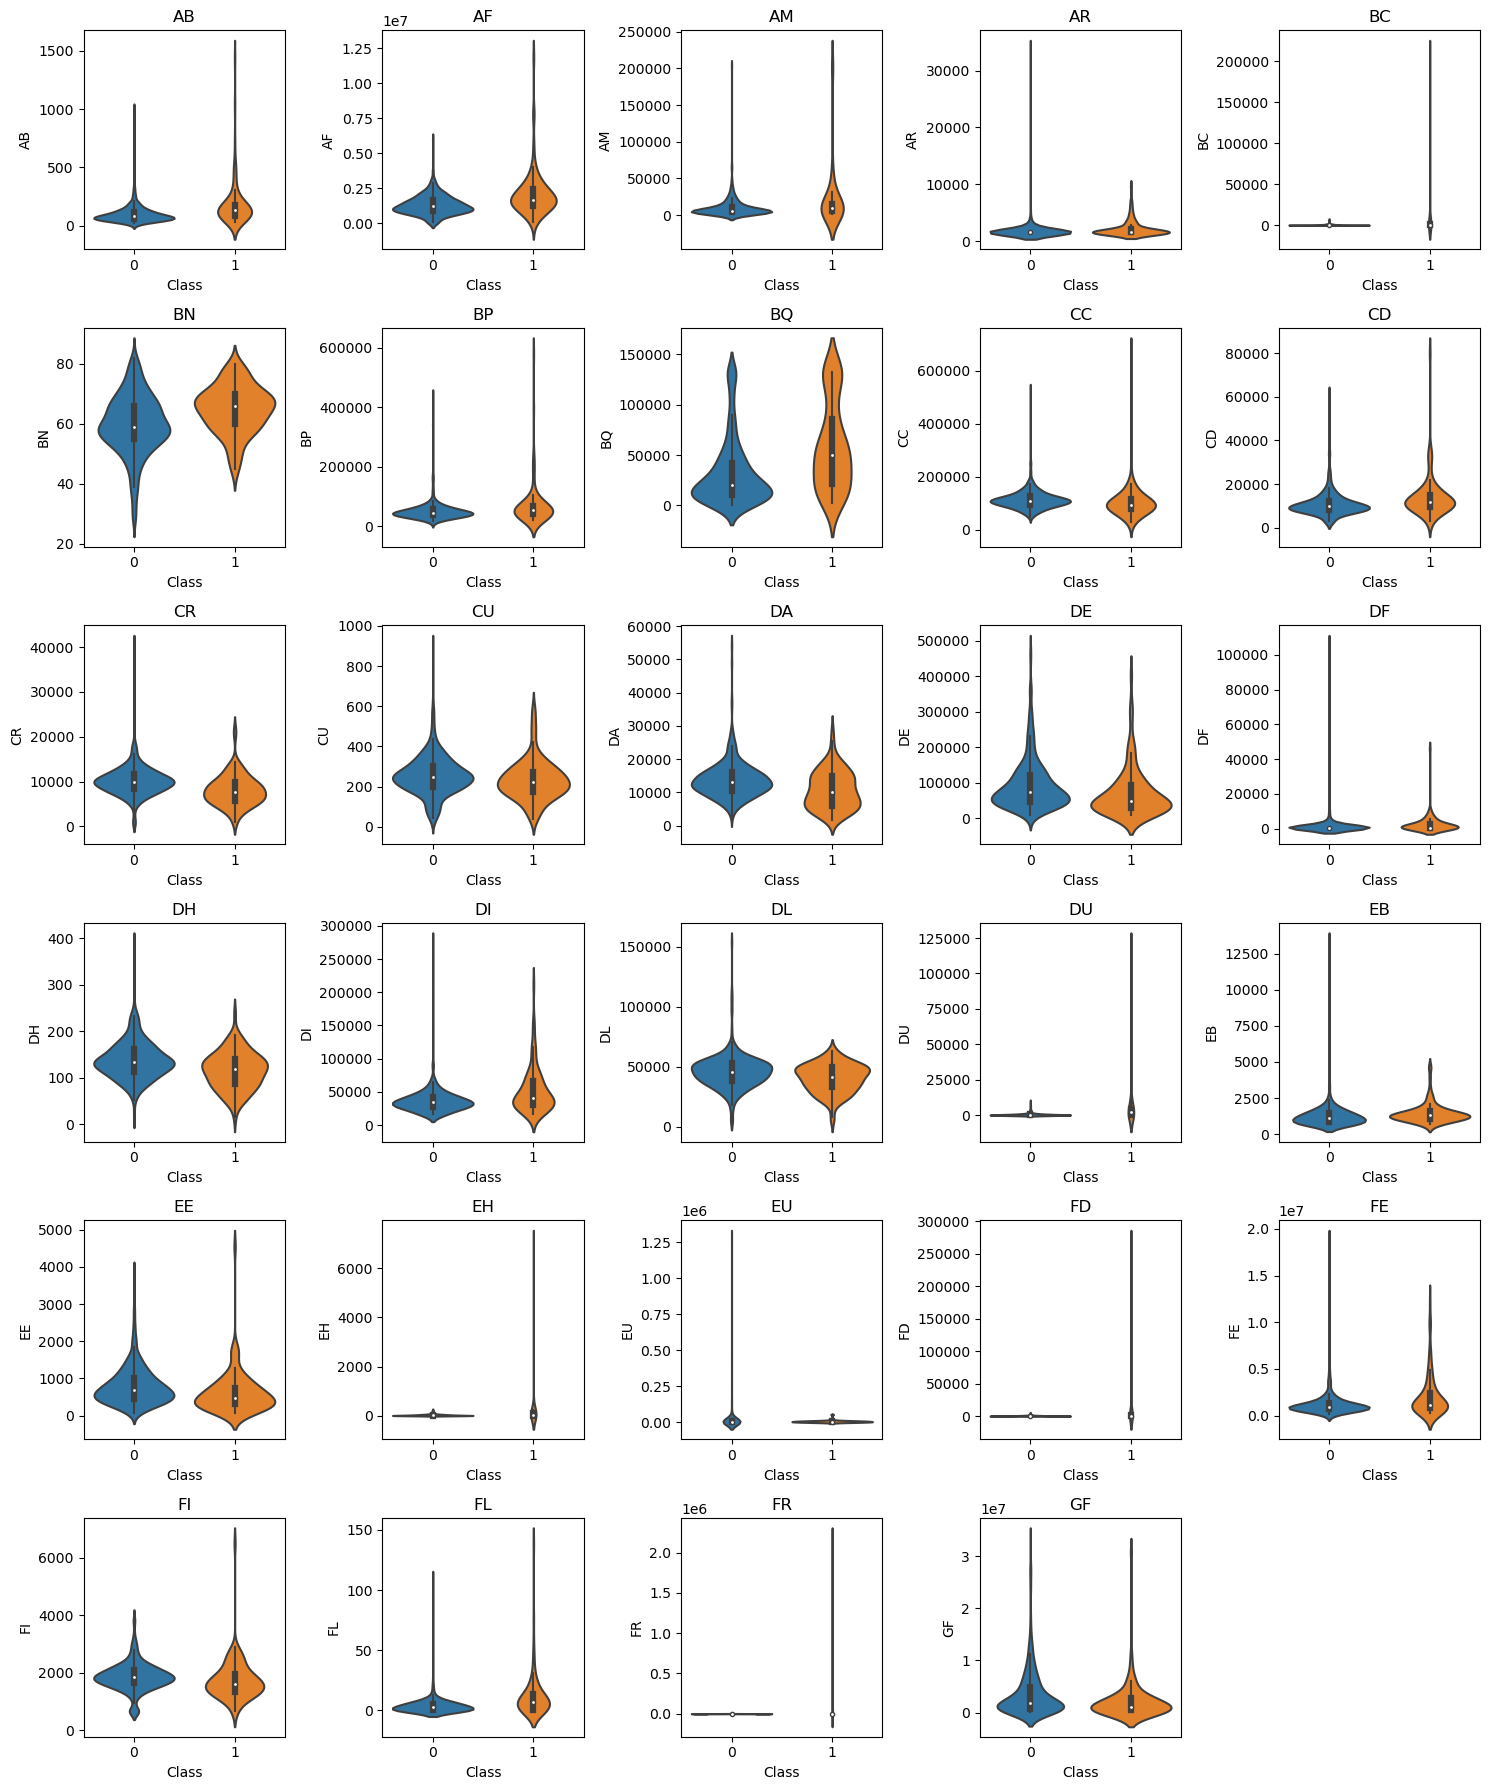

In [48]:
# plotting the distributions that differ
diff_distributions.extend(['Class'])

fig, axes = plt.subplots(6, 5, figsize=(15, 18))
axes = axes.flatten()

for i, column in enumerate(train_df[diff_distributions].columns[:-1]):

    sns.violinplot(x='Class', y=column, data=train_df[diff_distributions], ax=axes[i])
    axes[i].set_title(f"{column}")

# remove empty plots
for j in range(i+1, 6 * 5):
    fig.delaxes(axes[j])


fig.tight_layout()
plt.show()

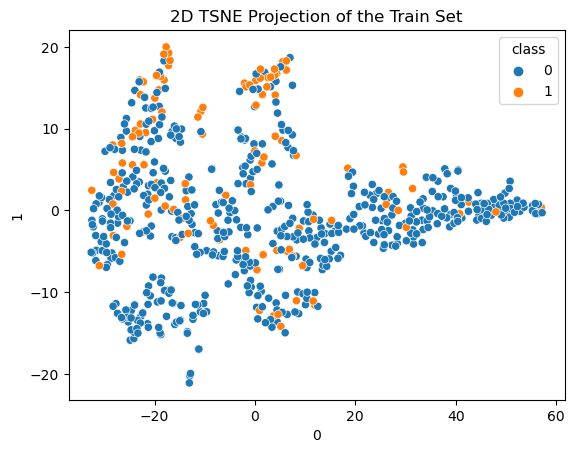

In [14]:
# clustering with TSNE to create a 2d plot. nothing
# stands out 
tsne = TSNE(n_components=2, random_state=442)

xformed = pd.DataFrame(
    tsne
    .fit_transform(train_df
                   .drop(columns=['Id','Class', 'unknown'])
                   .fillna(train_df.median(numeric_only=True)))
)

xformed['class'] = train_df['Class'].values

sns.scatterplot(x=0, y=1, data=xformed, hue='class')

plt.title("2D TSNE Projection of the Train Set")
plt.show()

In [15]:
# finding outliers to see if the models improve
# when they're excluded from the train sets 
from sklearn.ensemble import IsolationForest

# fitting outlier model
clf = IsolationForest()
clf.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median()))

# getting the outlier preds
outlier_preds = (
    clf
    .predict(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median(numeric_only=True))
            )
)

# the indices of the outliers
outlier_idx = (np.where(outlier_preds < 0)[0])

C:\Users\yaobv\AppData\Local\Temp\ipykernel_7412\487782852.py:7: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  clf.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon']).fillna(train_df.median()))


In [ ]:
# cross-validation loop to train several models

balance_score = []
fold_scores = []
fold_idxs = []
oofs = []
svc_oofs = []
xgb_oofs = []
tab_oofs = []

for n in range(25):

    skf = StratifiedKFold(n_splits=10, shuffle=True)
    ml_skf = MultilabelStratifiedKFold(n_splits=10, shuffle=True)

    X = train_df.drop(columns=['EJ']).copy()
    y = train_df['Class'].values
    
#     greek_df.iloc[:,1:-1]

    models = {}
    oof = np.zeros(len(X))
    xgb_oof = np.zeros(len(X))
    tab_oof = np.zeros(len(X))
    svc_oof = np.zeros(len(X))

    for i, (train, val) in enumerate(ml_skf.split(X, greek_df.iloc[:,1:-1])):
            
        # if we're dropping outliers from train, we can use the outlier 
        # idx above. never drop them from validation.
#         train = [i for i in train if i not in outlier_idx]

        train_x = X.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y[train]

        # getting the id values
        val_x = X.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y[val]
        
        # training the lgbm classifier
    
        
        
        model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 5000,
                           early_stopping_rounds=300,
                           subsample=0.7,
                           colsample_bytree=0.6,
                           max_depth=8,
                           class_weight='balanced',
                           metric='None',
                           is_unbalance=True)
        
        
        model.fit(train_x, train_y,
                  eval_set=[(val_x, val_y)],
                  eval_metric=lgb_metric,
                  early_stopping_rounds=300,
                  verbose=0)
        
        # training the SVC
        
        svc = SVC(C=5, probability=True, class_weight='balanced')
        svc_pipeline = make_pipeline(SimpleImputer(), StandardScaler(), svc)
        
        svc_pipeline.fit(train_x, train_y)
        
        # training xgb model
        
        xgb_model = XGBClassifier(learning_rate=0.06, scale_pos_weight=4.7)
        
        xgb_model.fit(train_x, train_y, eval_set=[(val_x, val_y)])
        
        preds = model.predict_proba(val_x)[:,1]        
        svc_preds = svc_pipeline.predict_proba(val_x)[:,1]
        xgb_preds = xgb_model.predict_proba(val_x)[:,1]
    
        oof[val] = preds
        models[f'model_{i}'] = model
        
        svc_oof[val] = svc_preds
        
        xgb_oof[val] = xgb_preds
        
        fold_scores.append(competition_log_loss(val_y, preds))
        fold_idxs.append([train, val])

    balance_score.append(competition_log_loss(y, oof))
    oofs.append(oof)
    svc_oofs.append(svc_oof)
    xgb_oofs.append(xgb_oof)
#     tab_oofs.append(tab_oof)

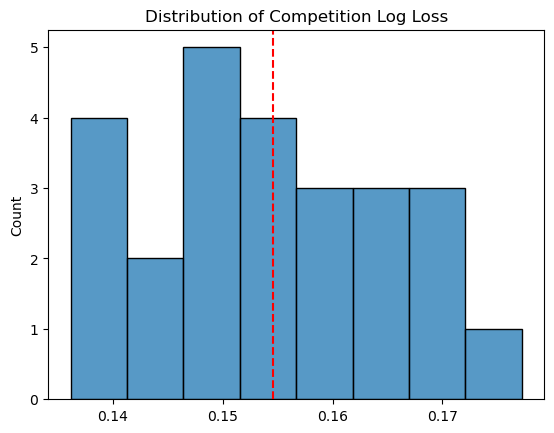

In [25]:
# plotting the distribution of competition log loss

sns.histplot(balance_score, bins=8)

plt.axvline(x=np.mean(balance_score), color='red', linestyle='--', label='s')
plt.title("Distribution of Competition Log Loss")
plt.show()

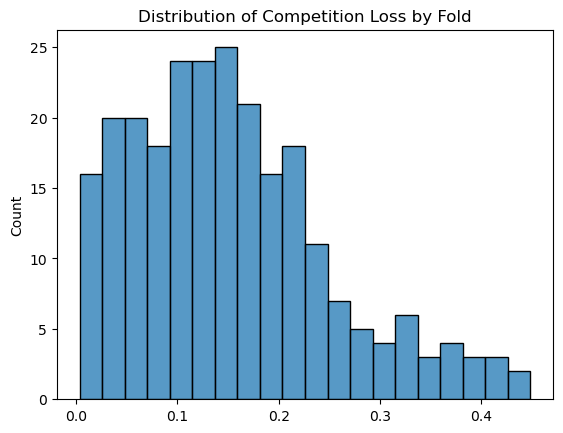

In [26]:
# examing scores by folds to see if there are any patterns
# in when the model learns poorly

sns.histplot(pd.Series(fold_scores), bins=20)
plt.title("Distribution of Competition Loss by Fold")
plt.show()

In [27]:
# every out of fold prediction for every patient

patient_preds = (pd.DataFrame(np.vstack(oofs)).T)
patient_preds['avg_pred'] = patient_preds.mean(axis=1)
patient_preds['median_pred'] = patient_preds.median(axis=1)
patient_preds['std_pred'] = patient_preds.std(axis=1)
patient_preds['min_pred'] = patient_preds.min(axis=1).round(5)
patient_preds['max_pred'] = patient_preds.max(axis=1)
patient_preds['y'] = y

In [28]:
competition_log_loss(y, patient_preds['median_pred'])

0.1344114583496523

In [29]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(patient_preds['y'], patient_preds['median_pred'], n_bins=20)

def plot_calibration(pred_limit=1):
    
    y_ = patient_preds.query("avg_pred <= 1")['y']
    x_ = patient_preds.query("avg_pred <= 1")['avg_pred']
                            
    prob_true_, prob_pred_ = calibration_curve(y_, x_, n_bins=20)
    
    fig, ax = plt.subplots()
    
    ax.set_ylim([0, 1])
    
    ax.errorbar(x=prob_pred_, y=prob_true_, yerr=abs(prob_true_ - prob_pred_) * 0.4, fmt=".k", label='Actual')    
    sns.scatterplot(x=prob_pred_, y=prob_true_)
    
    
    sns.lineplot(x=np.linspace(0, 1, 25), y=np.linspace(0, 1, 25), linestyle='--', label='Perfect Calibration')
    
    plt.title("Calibration Curve of Base Model")
    
    plt.show()

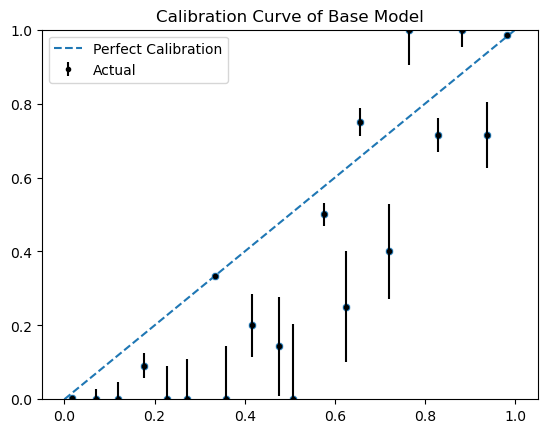

In [30]:
plot_calibration(pred_limit=1)

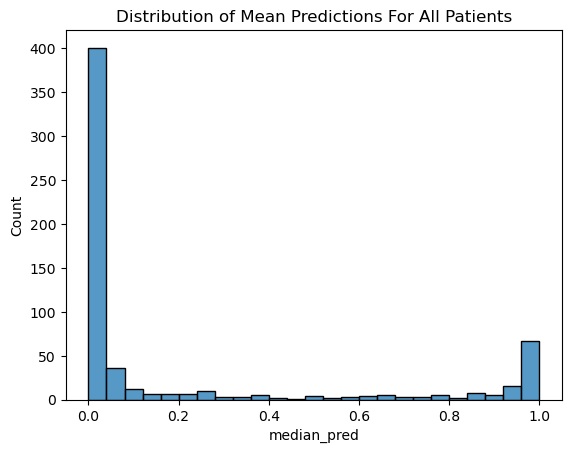

In [31]:
sns.histplot(patient_preds['median_pred'], bins=25)
plt.title("Distribution of Mean Predictions For All Patients")
plt.show()

Clearly most of our predictions are under 0.2. 

In [35]:
# creating a nested calibration cell

nested_fold = KFold(n_splits=10, shuffle=True)
X = train_df.drop(columns=['EJ']).copy()
y = train_df['Class'].values
outside_oof = np.zeros(len(X))

for i, (train_outer, val_outer) in enumerate(nested_fold.split(X, y)):
    
    # multilabel stratification
    ml_skf = MultilabelStratifiedKFold(n_splits=10, shuffle=True)
    
    # creating the outer training set that will be split for 
    # inner cross-validation
    X_train_outer = X.iloc[train_outer].copy()
    y_train_outer = y[train_outer]
    
    # creating the outer validation set that'll be used to generate
    # oof predictions
    X_val_outer = X.iloc[val_outer].copy()
    y_val_outer = y[val_outer]
    
    # filtering the greek df to only those rows in the train set
    greek_outer = greek_df.iloc[train_outer, 1:-1].copy()
    
    inner_oof = np.zeros(len(X_train_outer))

    models = {}
    oof = np.zeros(len(X))

    for j, (train, val) in enumerate(ml_skf.split(X_train_outer, greek_outer)):
        
        # the inner cross-validation loop       
 
        train_x = X_train_outer.iloc[train].drop(columns=['Id', 'Class']).copy()
        train_y = y_train_outer[train]

        # getting the id values
        val_x = X_train_outer.iloc[val].drop(columns=['Id', 'Class']).copy()
        val_y = y_train_outer[val]

        model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 5000,
                           early_stopping_rounds=300,
                           subsample=0.7,
                           colsample_bytree=0.6,
                           max_depth=8,
                           class_weight='balanced',
                           metric='None',
                           is_unbalance=True)

        model.fit(train_x, train_y, eval_set=[(val_x, val_y)], eval_metric=lgb_metric, verbose=False) 
        

        preds = model.predict_proba(val_x)[:,1]
        inner_oof[val] = preds
        
        # getting the score and saving the model
        score = competition_log_loss(val_y, preds)        
        models[f'model_{i}_{j}'] = model

    # generating the out of fold predictions using the models 
    # from the inner loop
    out_preds = []
    for key in models.keys():
        model_ = models[key]
        features = model_.feature_name_
        outer_pred_ = model_.predict_proba(X_val_outer[features])[:,1]
        out_preds.append(outer_pred_)
    
    # here we're using the *median* value of the model
    # predictions
    outside_oof[val_outer] = np.median(np.vstack(out_preds).T, axis=1)

In [36]:
print("competition loss on the nested val set:", 
      competition_log_loss(y, outside_oof))

competition loss on the nested val set: 0.40479298140179654


In [ ]:
importances = []
fi_df = train_df.drop(columns=['Id']).copy()

cv = StratifiedKFold(n_splits=10, shuffle=True)

data = Dataset(df=fi_df, target="Class", features=[col for col in fi_df.columns if col not in ['Class', 'AF', 'FL', 'EJ', 'FE', 'DI']])

model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced',
                           is_unbalance=True)

lofo_imp = LOFOImportance(data, cv=cv, scoring=custom_score, model=model)
importance_df = lofo_imp.get_importance()

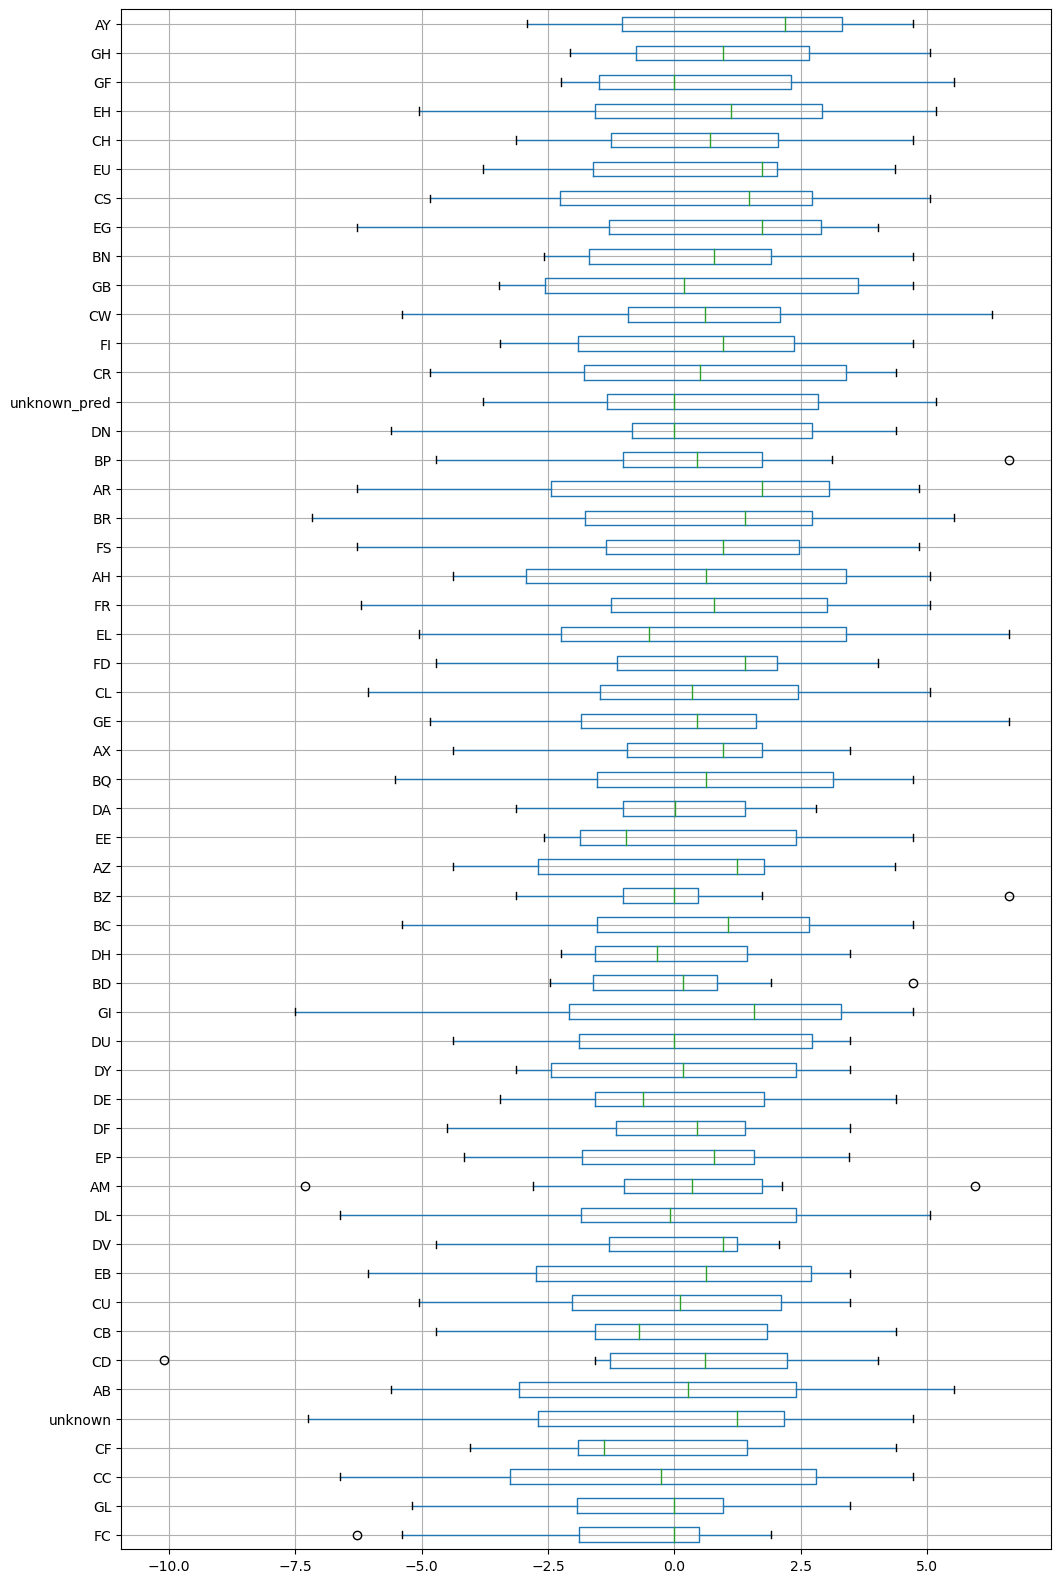

In [304]:
plot_importance(importance_df, figsize=(12, 20), kind='box')

In [403]:
model = lgm.LGBMClassifier(boosting_type='goss',
                           learning_rate=0.06733232950390658,
                           n_estimators = 888,
                           random_state=42,
                           subsample=0.6970532011679706,
                           colsample_bytree=0.6055755840633003,
                           max_depth=8,
                           class_weight='balanced',
                           is_unbalance=True)

In [320]:
from sklearn.calibration import IsotonicRegression
from sklearn.model_selection import LeaveOneOut

iso_cv = LeaveOneOut()

oof_calib = np.zeros(len(train_df))

X = patient_preds['mean_prediction']
y = patient_preds['actual']

for i, (train, val) in enumerate(iso_cv.split(X, y)):
    
    train_x = X[train]
    train_y = y[train]
    
    val_x = X[val]
    val_y = y[val]
    
    preds = []
    
    for v in val_x:
        iso_model1 = IsotonicRegression(out_of_bounds='clip')
        train_x_1 = np.concatenate([train_x, np.array([v])])
        train_y_1 = np.concatenate([train_y, [1]])
    
        iso_model1.fit(train_x_1, train_y_1)
    
        iso_model0 = IsotonicRegression(out_of_bounds='clip')
        train_x_0 = np.concatenate([train_x, np.array([v])])
        train_y_0 = np.concatenate([train_y, [0]])
    
        iso_model0.fit(train_x_0, train_y_0)
    
        pred_1 = iso_model1.predict(np.atleast_2d(v))
        pred_0 = iso_model0.predict(np.atleast_2d(v))
    
        final_pred = (0.5 * pred_1) + (0.5 * pred_0)
        
    preds.append(final_pred)
    
    oof_calib[val] = preds

In [414]:
from sklearn.feature_selection import RFECV

eliminated_list = []

for n in range(5):
    rc_spl = StratifiedKFold(n_splits=10, shuffle=True)

    rfecv = RFECV(
        estimator=model,
        step=0.1,
        cv=rc_spl,
        scoring="neg_log_loss",
    )
    rfecv.fit(train_df.drop(columns=['Id', 'Class', 'unknown', 'Epsilon', 'unknown_pred']), y)
    
    features_to_eliminate = rfecv.feature_names_in_[~rfecv.support_]
    eliminated_list.append(features_to_eliminate)

In [ ]:
counts = {}
elim_features = set(np.concatenate(eliminated_list))


for feature in np.concatenate(eliminated_list):
    if feature not in counts:
        counts[feature] = 1
    else:
        counts[feature] += 1

In [97]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
X = train_df.drop(columns=['EJ', 'unknown', 'Epsilon', 'AH', 'AR', 
                           'AY', 'AZ', 'BN', 'BR', 'BZ', 'DF', 'DV',
                           'Id', 'Class']).copy()

y = train_df['Class'].values

X = X.fillna(X.median())

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



In [95]:
def tf_competition_log_loss(y_true, y_pred):
    # Calculate the number of observations for each class
    N_0 = tf.reduce_sum(1 - y_true)
    N_1 = tf.reduce_sum(y_true)
    # Calculate the predicted probabilities for each class
    p_1 = tf.clip_by_value(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # Calculate the average log loss for each class
    log_loss_0 = -tf.reduce_sum((1 - y_true) * tf.math.log(p_0)) / N_0
    log_loss_1 = -tf.reduce_sum(y_true * tf.math.log(p_1)) / N_1
    # Return the (not further weighted) average of the averages
    return (log_loss_0 + log_loss_1) / 2

In [115]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
oof = np.zeros(len(X_scaled))

for i, (train, val) in enumerate(skf.split(X_scaled, y)):
    train_x = X_scaled[train]
    train_y = y[train]

    val_x = X_scaled[val]
    val_y = y[val]




    cnn_model = tf.keras.Sequential()

    cnn_model.add(layers.Dense(256, activation='relu'))
    cnn_model.add(layers.Reshape((32, 8)))
    cnn_model.add(layers.Conv1D(12, 2))
    cnn_model.add(layers.Conv1D(4, 2))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(12, activation='relu'))  
    cnn_model.add(layers.Dense(4, activation='relu'))
    cnn_model.add(layers.Dense(1, activation='sigmoid')) 

    cnn_model.compile(loss='binary_crossentropy', optimizer='adam')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    cnn_model.fit(train_x, train_y, validation_data=[val_x, val_y], callbacks=[early_stopping], epochs=500)

    preds = cnn_model.predict(val_x).flatten()

    oof[val] = preds

TypeError: __init__() got an unexpected keyword argument 'metrics'

In [113]:
competition_log_loss( y, oof)

0.4211988021402058